In [1]:
import argparse
import yaml
import time
import datetime
import cv2
import torch
from torch.autograd import Variable
import numpy as np
from astropy.visualization import make_lupton_rgb
import random
import numpy as np
from scipy.ndimage import zoom
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from scipy import ndimage, misc
import warnings
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
import sys


In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
!cp -r "/content/drive/My Drive/BerkeleyResults/Approach5/data_mosquito_final.zip" ./data_mosquito_final.zip

In [5]:
!unzip -q data_mosquito_final.zip

In [6]:
!ls

count = 4
print(count)

data_mosquito_final  data_mosquito_final.zip  drive  sample_data
4


(12, 104, 104)
shape (12, 104, 104)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


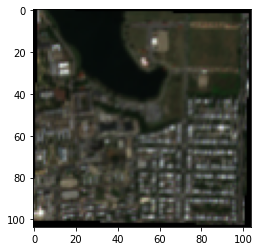

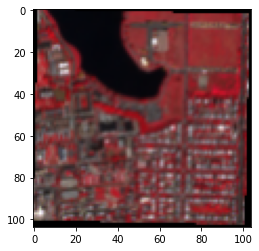

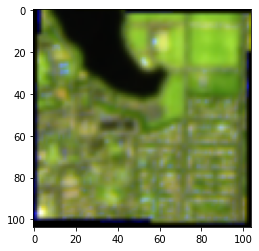

In [7]:
image = np.load('data_mosquito_final/data'+str(count)+'.npy')
print(image.shape)
count += 1

def paddedzoom(img, zoomfactor=0.8):
    out  = np.zeros_like(img)
    zoomed = cv2.resize(img, None, fx=zoomfactor, fy=zoomfactor)
    
    print(img.shape)
    h, w, _ = img.shape
    zh, zw, _ = zoomed.shape
    print(type((h-zh)/2))
    if zoomfactor<1:    # zero padded
        out[int((h-zh)/2):int(-(h-zh)/2),int((w-zw)/2):int(-(w-zw)/2),:] = zoomed
    else:               # clip out
        out = zoomed[int((zh-h)/2):int(-(zh-h)/2), int((zw-w)/2):int(-(zw-w)/2), :]

    return out


# image = np.flip(image, axis=2).copy()

# image =  np.swapaxes(image,0,2)
# va =  1.0 + (np.random.rand()/2 -0.25)
# image = paddedzoom(image, 0.5)
# image =  np.swapaxes(image,0,2)
print("shape", image.shape)


# ndvi = (B08 - B04) / (B08 + B04);
ndvi = (image[8] - image[4]) / (image[8] + image[4])

blue = cv2.normalize(image[1], None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
green = cv2.normalize(image[2], None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
red = cv2.normalize(image[3], None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
rgb1 = np.stack((red, green, blue), axis=2)


blue = cv2.normalize(image[2], None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
green = cv2.normalize(image[3], None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
red = cv2.normalize(image[7], None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

rgb2 = np.stack((red, green, blue), axis=2)

blue = cv2.normalize(image[3], None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
green = cv2.normalize(image[10], None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
red = cv2.normalize(image[11], None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
rgb3 = np.stack((red, green, blue), axis=2)

from matplotlib.pyplot import figure
from matplotlib import pyplot as PLT

import sys
np.set_printoptions(threshold=sys.maxsize)

where = [[1,1,1],
        [-1,-1,-1],
        [1,1,1]]
PLT.imshow(rgb1)
PLT.show()
PLT.imshow(rgb2)

#print(ndvi)
PLT.show()
PLT.imshow(rgb3)
PLT.show()

In [9]:
categorical_columns = ['TRAPTYPE', 'ATTRACTANTSUSED', 'SETTIMEOFDAY', 'COLLECTTIMEOFDAY', 'GENUS', 'SPECIES', 'TRAPID','TRAPSITE']
numerical_columns = ['LATITUDE', 'LONGITUDE', 'TRAPSET', 'YEAR','TRAPCOLLECT', 'DIFF_DAYS']

weather_columns = ['sunriseTime', 'sunsetTime', 'moonPhase', 
                     'precipIntensity', 'precipIntensityMax', 'precipProbability', 'temperatureHigh', 'temperatureHighTime',
                     'temperatureLow', 'temperatureLowTime', 'apparentTemperatureHigh', 'apparentTemperatureHighTime',
                     'apparentTemperatureLow', 'apparentTemperatureLowTime', 'dewPoint', 'humidity', 'pressure', 'windSpeed', 'windGust', 
                     'windGustTime', 'windBearing', 'cloudCover', 'uvIndex', 'uvIndexTime','visibility', 'temperatureMin',
                     'temperatureMinTime', 'temperatureMax', 'temperatureMaxTime', 'apparentTemperatureMin','apparentTemperatureMinTime', 'apparentTemperatureMax',
                     'apparentTemperatureMaxTime','time']

for item in weather_columns:
    numerical_columns.append(item + str(14))

In [17]:
sentinel_frame = pd.read_csv('/content/drive/My Drive/BerkeleyResults/Approach4/aedes_original_mosquito_weather_semi_clean.csv')
sentinel_frame["TRAPSET"]= pd.to_datetime(sentinel_frame["TRAPSET"])
sentinel_frame["TRAPCOLLECT"]= pd.to_datetime(sentinel_frame["TRAPCOLLECT"])
sentinel_frame["DIFF_DAYS"] = (sentinel_frame["TRAPCOLLECT"] - sentinel_frame["TRAPSET"]).dt.days
sentinel_frame["TRAPSET"]= sentinel_frame["TRAPSET"].dt.week
sentinel_frame["TRAPCOLLECT"]= sentinel_frame["TRAPCOLLECT"].dt.week

for category in categorical_columns:
    sentinel_frame[category] = sentinel_frame[category].astype('category')

categorical_column_sizes = [len(sentinel_frame[column].cat.categories) for column in categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]

for col in numerical_columns:
    sentinel_frame[col] = (sentinel_frame[col] - sentinel_frame[col].mean()) / (sentinel_frame[col].max() - sentinel_frame[col].min())
    
def get_categorical_tensor(in_frame, categories):
    categorical_data = np.stack([in_frame[col].cat.codes.values for col in categories], 1)
    categorical_data = torch.tensor(categorical_data, dtype=torch.int64)
    return categorical_data

def get_numerical_tensor(in_frame, numerical_columns):
    numerical_data = np.stack([in_frame[col].values for col in numerical_columns], 1)
    numerical_data = torch.tensor(numerical_data, dtype=torch.float)
    return numerical_data

count = 0
for i in sentinel_frame.columns:
    print(count, i)
    count+= 1

0 Unnamed: 0
1 X
2 Y
3 OBJECTID
4 TRAPTYPE
5 ATTRACTANTSUSED
6 TRAPID
7 LATITUDE
8 LONGITUDE
9 ADDRESS
10 TOWN
11 STATE
12 COUNTY
13 TRAPSITE
14 TRAPSET
15 SETTIMEOFDAY
16 TRAPCOLLECT
17 YEAR
18 COLLECTTIMEOFDAY
19 GENUS
20 SPECIES
21 TOTAL
22 sunriseTime1
23 sunsetTime1
24 moonPhase1
25 precipIntensity1
26 precipIntensityMax1
27 precipProbability1
28 temperatureHigh1
29 temperatureHighTime1
30 temperatureLow1
31 temperatureLowTime1
32 apparentTemperatureHigh1
33 apparentTemperatureHighTime1
34 apparentTemperatureLow1
35 apparentTemperatureLowTime1
36 dewPoint1
37 humidity1
38 pressure1
39 windSpeed1
40 windGust1
41 windGustTime1
42 windBearing1
43 cloudCover1
44 uvIndex1
45 uvIndexTime1
46 visibility1
47 temperatureMin1
48 temperatureMinTime1
49 temperatureMax1
50 temperatureMaxTime1
51 apparentTemperatureMin1
52 apparentTemperatureMinTime1
53 apparentTemperatureMax1
54 apparentTemperatureMaxTime1
55 icon1
56 time1
57 precipIntensityMaxTime1
58 precipType1
59 summary1
60 sunriseTime2


In [18]:
def paddedzoom(img, zoomfactor=0.8):
    out  = np.zeros_like(img)
    zoomed = cv2.resize(img, None, fx=zoomfactor, fy=zoomfactor)
    
    h, w, _ = img.shape
    zh, zw, _ = zoomed.shape
    if zoomfactor<1:    
        out[int((h-zh)/2):int(-(h-zh)/2),int((w-zw)/2):int(-(w-zw)/2),:] = zoomed
    else:
        out = zoomed[int((zh-h)/2):int(-(zh-h)/2), int((zw-w)/2):int(-(zw-w)/2), :]

    return out

def get_random_crop(image, crop_height, crop_width):

    original_shape = image.shape
    max_x = image.shape[1] - crop_width
    max_y = image.shape[0] - crop_height

    x = np.random.randint(0, max_x)
    y = np.random.randint(0, max_y)

    crop = image[y: y + crop_height, x: x + crop_width]
    resized = cv2.resize(crop, (104, 104), interpolation = cv2.INTER_AREA)

    return resized

def get_affeine(img, rows, cols):
    offset1 = ((random.random() * 2 ) - 1) *10
    offset2 = ((random.random() * 2 ) - 1) *10
    M = np.float32([[1,0,offset1],[0,1,offset2]])
    dst = cv2.warpAffine(img,M,(cols,rows))

    return dst

class SentinelDataset(Dataset):

    def __init__(self, root_dir, data, transform=None):
        self.data = data
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        

        filename = str('data' + str(self.data.iloc[idx, 3])+'.npy')
        img_name = os.path.join(self.root_dir, filename)
        
        image = np.load(img_name)

        #random flip
        if np.random.rand() > 0.5:
            image = np.flip(image, axis=2).copy()
        
        #random rotate
        image = ndimage.rotate(image, random.randint(0,359), axes = [1,2],reshape=False)

        image = np.swapaxes(image,0,2)
        or_image = image.copy()
        image = paddedzoom(image, 1.0 + (np.random.rand()/2) )
        if image.shape != or_image.shape:
            image = or_image
        image = get_random_crop(image, 80, 80)
        image = get_affeine(image, 104, 104)
        image =  np.swapaxes(image,0,2)

        blue = cv2.normalize(image[1], None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        green = cv2.normalize(image[2], None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        red = cv2.normalize(image[3], None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

        ch2 = cv2.normalize(image[2], None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        ch3 = cv2.normalize(image[3], None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        ch8 = cv2.normalize(image[7], None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

        ch3 = cv2.normalize(image[3], None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        ch8 = cv2.normalize(image[10], None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        ch11 = cv2.normalize(image[11], None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

        rgb = np.stack((red, green, blue), axis=2)
        veg = np.stack((ch2, ch3, ch8), axis=2)
        soil = np.stack((ch3, ch8, ch11), axis=2)

        target = self.data.iloc[idx, 21]
        image_tensor = torch.from_numpy(rgb)
        veg_tensor = torch.from_numpy(veg)
        soil_tensor = torch.from_numpy(soil)

        current_row = self.data.iloc[[idx]]
        categorical_data = np.stack([current_row[col].cat.codes.values for col in categorical_columns], 1)
        numerical_data = np.stack([current_row[col].values for col in numerical_columns], 1)

        return image_tensor, veg_tensor, soil_tensor, target, categorical_data, numerical_data

In [19]:
import torch
import torch.nn as nn

from collections import defaultdict

class Flatten(torch.nn.Module):
    def forward(self, x):
        x = x.view(1, -1)
        return x

def add_conv(in_ch, out_ch, ksize, stride):
    stage = nn.Sequential()
    pad = (ksize - 1) // 2
    stage.add_module('conv', nn.Conv2d(in_channels=in_ch,
                                       out_channels=out_ch, kernel_size=ksize, stride=stride,
                                       padding=pad, bias=False))
    stage.add_module('batch_norm', nn.BatchNorm2d(out_ch))
    stage.add_module('leaky', nn.LeakyReLU(0.1))
    return stage

def add_linear(in_ch, in_dm, out_ch, leaky = True):
    stage = nn.Sequential()
    stage.add_module('linear', nn.Linear(in_features=in_ch*in_dm*in_dm, out_features=out_ch))
    #stage.add_module('batch_norm',nn.BatchNorm1d(num_features=out_ch))
    if leaky :
        stage.add_module('sigmoid', nn.Sigmoid())
    else:
        stage.add_module('relu', nn.ReLU())

    return stage


class resblock(nn.Module):
    def __init__(self, ch, nblocks=1, shortcut=True):

        super().__init__()
        self.shortcut = shortcut
        self.module_list = nn.ModuleList()
        for i in range(nblocks):
            resblock_one = nn.ModuleList()
            resblock_one.append(add_conv(ch, ch//2, 1, 1))
            resblock_one.append(add_conv(ch//2, ch, 3, 1))
            self.module_list.append(resblock_one)

    def forward(self, x):
        for module in self.module_list:
            h = x
            for res in module:
                h = res(h)
            x = x + h if self.shortcut else h
        return x

def create_darknet_modules():

    # DarkNet53
    mlist = nn.ModuleList()
    mlist.append(add_conv(in_ch=3, out_ch=32, ksize=3, stride=1))
    mlist.append(add_conv(in_ch=32, out_ch=64, ksize=3, stride=2))
    mlist.append(resblock(ch=64))
    mlist.append(add_conv(in_ch=64, out_ch=128, ksize=3, stride=2))
    mlist.append(resblock(ch=128, nblocks=2))
    mlist.append(add_conv(in_ch=128, out_ch=256, ksize=3, stride=2))
    mlist.append(resblock(ch=256, nblocks=8))
    mlist.append(add_conv(in_ch=256, out_ch=512, ksize=3, stride=2))
    mlist.append(resblock(ch=512, nblocks=8)) 
    mlist.append(add_conv(in_ch=512, out_ch=1024, ksize=3, stride=2))
    mlist.append(resblock(ch=1024, nblocks=4))

    mlist.append(Flatten())
    mlist.append(add_linear(in_ch=1024*3, in_dm=4, out_ch=4096))
    mlist.append(add_linear(in_ch=4096, in_dm=1, out_ch=1024))
    mlist.append(add_linear(in_ch=1024, in_dm=1, out_ch=65))

    #mlist.append(add_linear(in_ch=1024, in_dm=1, out_ch=1, leaky = False))

    return mlist

def create_neural_modules(embedding_size, num_numerical_cols, output_size, hidden_size, dropout = 0.3):
    all_layers = []
    num_categorical_cols = sum((nf for ni, nf in embedding_size))
    input_size = num_categorical_cols + num_numerical_cols
    all_layers.append(nn.Linear(input_size, hidden_size))
    all_layers.append(nn.Sigmoid())
    all_layers.append(nn.Dropout(dropout))

    all_layers.append(nn.Linear(hidden_size, hidden_size))
    all_layers.append(nn.Sigmoid())
    all_layers.append(nn.Dropout(dropout))

    all_layers.append(nn.Linear(hidden_size, hidden_size))
    all_layers.append(nn.Sigmoid())
    all_layers.append(nn.Dropout(dropout))

    # all_layers.append(nn.Linear(hidden_size, output_size))
    # all_layers.append(nn.Sigmoid())

    return nn.Sequential(*all_layers)

def create_mix_modules(input_size, output_size, dropout = 0.3):
    all_layers = []
    all_layers.append(nn.Linear(input_size, input_size))
    all_layers.append(nn.Sigmoid())
    all_layers.append(nn.Dropout(dropout))

    all_layers.append(nn.Linear(input_size, input_size))
    all_layers.append(nn.Sigmoid())
    all_layers.append(nn.Dropout(dropout))

    all_layers.append(nn.Linear(input_size, output_size))
    all_layers.append(nn.ReLU())
    return nn.Sequential(*all_layers)

def turn_conv_lstm_autograd(self):

    def dfs_off(model):
        for name, child in model.named_children():
            for param in child.parameters():
                param.requires_grad = False
            dfs_off(child)

    for i, module in enumerate(self.module_list):
        if i == 11:
          break
        dfs_off(module)

class Sentinel_net(nn.Module):

    def __init__(self, embedding_size, num_numerical_cols, output_size):
        super(Sentinel_net, self).__init__()
        self.module_list = create_darknet_modules()
        turn_conv_lstm_autograd(self)
    
        self.layers = create_neural_modules(embedding_size, num_numerical_cols, output_size, 65)
        self.mix_layers = create_mix_modules(130, 1)
        self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
        self.embedding_dropout = nn.Dropout(0.3)

    def forward(self, x, x_categorical, x_numerical):
        for i, module in enumerate(self.module_list):
            x = module(x)
        x = x.squeeze(dim=0)
        embeddings = []
        for i, e in enumerate(self.all_embeddings):
            embeddings.append(e(x_categorical[:, i]))
        

        y = torch.cat(embeddings, 1)

        y = self.embedding_dropout(y)
        y = torch.cat([y, x_numerical], 1)
        y = self.layers(y).squeeze()
        mixtensor = torch.cat((x, y), 0)
        mixtensor = self.mix_layers(mixtensor)
        return mixtensor

In [20]:
from __future__ import division
import torch
import numpy as np


def parse_conv_block(m, weights, offset, initflag):
    """
    Initialization of conv layers with batchnorm
    Args:
        m (Sequential): sequence of layers
        weights (numpy.ndarray): pretrained weights data
        offset (int): current position in the weights file
        initflag (bool): if True, the layers are not covered by the weights file. \
            They are initialized using darknet-style initialization.
    Returns:
        offset (int): current position in the weights file
        weights (numpy.ndarray): pretrained weights data
    """
    conv_model = m[0]
    bn_model = m[1]
    param_length = m[1].bias.numel()

    # batchnorm
    for pname in ['bias', 'weight', 'running_mean', 'running_var']:
        layerparam = getattr(bn_model, pname)

        if initflag: # yolo initialization - scale to one, bias to zero
            if pname == 'weight':
                weights = np.append(weights, np.ones(param_length))
            else:
                weights = np.append(weights, np.zeros(param_length))

        param = torch.from_numpy(weights[offset:offset + param_length]).view_as(layerparam)
        layerparam.data.copy_(param)
        offset += param_length

    param_length = conv_model.weight.numel()

    # conv
    if initflag: # yolo initialization
        n, c, k, _ = conv_model.weight.shape
        scale = np.sqrt(2 / (k * k * c))
        weights = np.append(weights, scale * np.random.normal(size=param_length))

    param = torch.from_numpy(
        weights[offset:offset + param_length]).view_as(conv_model.weight)
    conv_model.weight.data.copy_(param)
    offset += param_length

    return offset, weights

def parse_yolo_block(m, weights, offset, initflag):
    """
    YOLO Layer (one conv with bias) Initialization
    Args:
        m (Sequential): sequence of layers
        weights (numpy.ndarray): pretrained weights data
        offset (int): current position in the weights file
        initflag (bool): if True, the layers are not covered by the weights file. \
            They are initialized using darknet-style initialization.
    Returns:
        offset (int): current position in the weights file
        weights (numpy.ndarray): pretrained weights data
    """
    conv_model = m._modules['conv']
    param_length = conv_model.bias.numel()

    if initflag: # yolo initialization - bias to zero
        weights = np.append(weights, np.zeros(param_length))

    param = torch.from_numpy(
        weights[offset:offset + param_length]).view_as(conv_model.bias)
    conv_model.bias.data.copy_(param)
    offset += param_length

    param_length = conv_model.weight.numel()

    if initflag: # yolo initialization
        n, c, k, _ = conv_model.weight.shape
        scale = np.sqrt(2 / (k * k * c))
        weights = np.append(weights, scale * np.random.normal(size=param_length))
 
    param = torch.from_numpy(
        weights[offset:offset + param_length]).view_as(conv_model.weight)
    conv_model.weight.data.copy_(param)
    offset += param_length

    return offset, weights

def parse_yolo_weights(model, weights_path):
    """
    Parse YOLO (darknet) pre-trained weights data onto the pytorch model
    Args:
        model : pytorch model object
        weights_path (str): path to the YOLO (darknet) pre-trained weights file
    """
    fp = open(weights_path, "rb")

    # skip the header
    header = np.fromfile(fp, dtype=np.int32, count=5) # not used
    # read weights 
    weights = np.fromfile(fp, dtype=np.float32)
    fp.close()

    offset = 0 
    initflag = False #whole yolo weights : False, darknet weights : True

    for m in model.module_list:
        if m._get_name() == 'Sequential':
            # normal conv block
            offset, weights = parse_conv_block(m, weights, offset, initflag)

        elif m._get_name() == 'resblock':
            # residual block
            for modu in m._modules['module_list']:
                for blk in modu:
                    offset, weights = parse_conv_block(blk, weights, offset, initflag)
        else:
            break
        # elif m._get_name() == 'YOLOLayer':
        #     # YOLO Layer (one conv with bias) Initialization
        #     offset, weights = parse_yolo_block(m, weights, offset, initflag)

        # initflag = (offset >= len(weights)) # the end of the weights file. turn the flag on

In [21]:
def train_darknet_net(sentinel_dataset_train,sentinel_dataset_test, fold_count):
    model = Sentinel_net(categorical_embedding_sizes,len(numerical_columns),1)
    parse_yolo_weights(model, "/content/drive/My Drive/Colab/mosquito/darknet53.conv.74")
    model = model.cuda()
    model.train()

    # criterion = torch.nn.MSELoss(size_average = True) 
    criterion = torch.nn.L1Loss()

    params_dict = dict(model.named_parameters())
    params = []
    base_lr = 0.00001

    for key, value in params_dict.items():
        if value.requires_grad:
          print(key)
          if 'weight' in key:
              params += [{'params':value, 'weight_decay':4e-3}]
          else:
              params += [{'params':value, 'weight_decay':0.0}]

    optimizer = torch.optim.RMSprop(params, lr=base_lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0.9, centered=False)

    epochs = 21
    min_eval = sys.maxsize
    current_score = 0

    for epoch in range(0,epochs):
        loss_sum = 0
        
        model.train()

        for i_batch, sample_batched in enumerate(train_dataset_loader):
            img = sample_batched[0].cuda()
            vgt = sample_batched[1].cuda()
            soil = sample_batched[2].cuda()

            C = sample_batched[4].squeeze(dim=0).type(torch.int64).cuda()
            A = sample_batched[5].squeeze(dim=0).type(torch.float).cuda()
            image = torch.stack([img, vgt, soil], dim=0).squeeze().float()

            image = image.permute(0,3,2,1)/255
            y_pred = model(image, C, A)
            y = sample_batched[3].cuda().float()
            loss = criterion(y_pred, y) 
            loss.backward() 
            loss_sum += loss.item()
            optimizer.step() 
            optimizer.zero_grad() 

        model.eval()
        print('Train Accuracy epoch {}, loss {} %'.format(epoch, loss_sum))

        with torch.no_grad():

            if epoch % 10 == 0:
                model.eval()
                eval_loss_sum = 0 
                result_pred = []
                result_act = []
                with torch.no_grad():
                    y2 = None
                    y_pred2 = None
                    for i_batch2, sample_batched2 in enumerate(test_dataset_loader):

                        img2 = sample_batched2[0].cuda()
                        vgt2 = sample_batched2[1].cuda()
                        soil2 = sample_batched2[2].cuda()
                        C2 = sample_batched2[4].squeeze(dim=0).type(torch.int64).cuda()
                        A2 = sample_batched2[5].squeeze(dim=0).type(torch.float).cuda()
                        image2 = torch.stack([img2, vgt2, soil2], dim=1).squeeze().float()
                        image2 = image2.permute(0,3,2,1)/255

                        y_pred2 = model(image2,C2,A2)
                        y2 = sample_batched2[3].cuda().float()
                        eval_loss_sum += criterion(y_pred2, y2) 
                        result_pred += y_pred2.tolist()
                        result_act += y2.tolist()
                    
                    print('')
                    print(' Test Accuracy  {} %'.format( eval_loss_sum))


                    if eval_loss_sum < min_eval:
                        current_score = mean_absolute_error(result_pred, result_act)
                        print("Score!" ,current_score )
                        min_eval = eval_loss_sum
                        print("saved!" ,current_score )
                        torch.save({'iter': epoch,
                          'model_state_dict': model.state_dict(),
                          'optimizer_state_dict': optimizer.state_dict(),
                          'best_ac': min_eval,
                          },
                          os.path.join('/content/drive/My Drive/BerkeleyResults/Approach4/aedes_best_approach' + str(fold_count) + '.ckpt'))


    return current_score

In [22]:
start_time = time.time()

scores = []
cv = KFold(n_splits=5, random_state=42, shuffle=True)
fold_count = 0
for train_index, test_index in cv.split(sentinel_frame, None):
    print('Fold')
    train, test  = sentinel_frame.iloc[train_index], sentinel_frame.iloc[test_index]

    sentinel_dataset_train = SentinelDataset(data=train, root_dir='data_mosquito_final/')
    sentinel_dataset_test = SentinelDataset(data=test, root_dir='data_mosquito_final/')

    train_dataset_loader = torch.utils.data.DataLoader(dataset=sentinel_dataset_train,
                                                    batch_size=1,
                                                    shuffle=False)
    
    test_dataset_loader = torch.utils.data.DataLoader(dataset=sentinel_dataset_test,
                                                    batch_size=1,
                                                    shuffle=False)
    

    current_score = train_darknet_net(sentinel_dataset_train,sentinel_dataset_test, fold_count)
    scores.append(current_score)
    fold_count += 1
print(scores)
print( sum(scores) / len(scores) )
print("--- %s seconds ---" % (time.time() - start_time))

Fold
module_list.12.linear.weight
module_list.12.linear.bias
module_list.13.linear.weight
module_list.13.linear.bias
module_list.14.linear.weight
module_list.14.linear.bias
layers.0.weight
layers.0.bias
layers.3.weight
layers.3.bias
layers.6.weight
layers.6.bias
mix_layers.0.weight
mix_layers.0.bias
mix_layers.3.weight
mix_layers.3.bias
mix_layers.6.weight
mix_layers.6.bias
all_embeddings.0.weight
all_embeddings.1.weight
all_embeddings.2.weight
all_embeddings.3.weight
all_embeddings.4.weight
all_embeddings.5.weight
all_embeddings.6.weight
all_embeddings.7.weight
Train Accuracy epoch 0, loss 3576.6372014284134 %

 Test Accuracy  782.2918701171875 %
Score! 4.601716630599078
saved! 4.601716630599078
Train Accuracy epoch 1, loss 3318.6768097877502 %
Train Accuracy epoch 2, loss 3318.482161998749 %
Train Accuracy epoch 3, loss 3312.8262543678284 %
Train Accuracy epoch 4, loss 3311.1693046092987 %
Train Accuracy epoch 5, loss 3314.748698234558 %
Train Accuracy epoch 6, loss 3320.137826681137

In [26]:
def train_darknet_net(sentinel_dataset_train,sentinel_dataset_test, fold_count):
    model = Sentinel_net(categorical_embedding_sizes,len(numerical_columns),1)
    parse_yolo_weights(model, "/content/drive/My Drive/Colab/mosquito/darknet53.conv.74")
    model = model.cuda()
    model.train()

    # criterion = torch.nn.MSELoss(size_average = True) 
    criterion = torch.nn.L1Loss()

    params_dict = dict(model.named_parameters())
    params = []
    base_lr = 0.0001

    for key, value in params_dict.items():
        if value.requires_grad:
          print(key)
          if 'weight' in key:
              params += [{'params':value, 'weight_decay':4e-3}]
          else:
              params += [{'params':value, 'weight_decay':0.0}]

    optimizer = torch.optim.RMSprop(params, lr=base_lr, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0.9, centered=False)

    epochs = 51
    min_eval = sys.maxsize
    current_score = 0

    for epoch in range(0,epochs):
        loss_sum = 0
        
        model.train()

        for i_batch, sample_batched in enumerate(train_dataset_loader):
            img = sample_batched[0].cuda()
            vgt = sample_batched[1].cuda()
            soil = sample_batched[2].cuda()

            C = sample_batched[4].squeeze(dim=0).type(torch.int64).cuda()
            A = sample_batched[5].squeeze(dim=0).type(torch.float).cuda()
            image = torch.stack([img, vgt, soil], dim=0).squeeze().float()

            image = image.permute(0,3,2,1)/255
            y_pred = model(image, C, A)
            y = sample_batched[3].cuda().float()
            loss = criterion(y_pred, y) 
            loss.backward() 
            loss_sum += loss.item()
            optimizer.step() 
            optimizer.zero_grad() 

        model.eval()
        print('Train Accuracy epoch {}, loss {} %'.format(epoch, loss_sum))

        with torch.no_grad():

            if epoch % 10 == 0:
                model.eval()
                eval_loss_sum = 0 
                result_pred = []
                result_act = []
                with torch.no_grad():
                    y2 = None
                    y_pred2 = None
                    for i_batch2, sample_batched2 in enumerate(test_dataset_loader):

                        img2 = sample_batched2[0].cuda()
                        vgt2 = sample_batched2[1].cuda()
                        soil2 = sample_batched2[2].cuda()
                        C2 = sample_batched2[4].squeeze(dim=0).type(torch.int64).cuda()
                        A2 = sample_batched2[5].squeeze(dim=0).type(torch.float).cuda()
                        image2 = torch.stack([img2, vgt2, soil2], dim=1).squeeze().float()
                        image2 = image2.permute(0,3,2,1)/255

                        y_pred2 = model(image2,C2,A2)
                        y2 = sample_batched2[3].cuda().float()
                        eval_loss_sum += criterion(y_pred2, y2) 
                        result_pred += y_pred2.tolist()
                        result_act += y2.tolist()
                    
                    print('')
                    print(' Test Accuracy  {} %'.format( eval_loss_sum))


                    if eval_loss_sum < min_eval:
                        current_score = mean_absolute_error(result_pred, result_act)
                        print("Score!" ,current_score )
                        min_eval = eval_loss_sum
                        print("saved!" ,current_score )
                        torch.save({'iter': epoch,
                          'model_state_dict': model.state_dict(),
                          'optimizer_state_dict': optimizer.state_dict(),
                          'best_ac': min_eval,
                          },
                          os.path.join('/content/drive/My Drive/BerkeleyResults/Approach4/aedes_best_approach' + str(fold_count) + '.ckpt'))


    return current_score

In [27]:
start_time = time.time()

scores = []
cv = KFold(n_splits=5, random_state=42, shuffle=True)
fold_count = 0
for train_index, test_index in cv.split(sentinel_frame, None):
    print('Fold')
    train, test  = sentinel_frame.iloc[train_index], sentinel_frame.iloc[test_index]

    sentinel_dataset_train = SentinelDataset(data=train, root_dir='data_mosquito_final/')
    sentinel_dataset_test = SentinelDataset(data=test, root_dir='data_mosquito_final/')

    train_dataset_loader = torch.utils.data.DataLoader(dataset=sentinel_dataset_train,
                                                    batch_size=1,
                                                    shuffle=False)
    
    test_dataset_loader = torch.utils.data.DataLoader(dataset=sentinel_dataset_test,
                                                    batch_size=1,
                                                    shuffle=False)
    

    current_score = train_darknet_net(sentinel_dataset_train,sentinel_dataset_test, fold_count)
    scores.append(current_score)
    fold_count += 1
print(scores)
print( sum(scores) / len(scores) )
print("--- %s seconds ---" % (time.time() - start_time))

Fold
module_list.12.linear.weight
module_list.12.linear.bias
module_list.13.linear.weight
module_list.13.linear.bias
module_list.14.linear.weight
module_list.14.linear.bias
layers.0.weight
layers.0.bias
layers.3.weight
layers.3.bias
layers.6.weight
layers.6.bias
mix_layers.0.weight
mix_layers.0.bias
mix_layers.3.weight
mix_layers.3.bias
mix_layers.6.weight
mix_layers.6.bias
all_embeddings.0.weight
all_embeddings.1.weight
all_embeddings.2.weight
all_embeddings.3.weight
all_embeddings.4.weight
all_embeddings.5.weight
all_embeddings.6.weight
all_embeddings.7.weight
Train Accuracy epoch 0, loss 3360.8099442720413 %

 Test Accuracy  784.66162109375 %
Score! 4.615655831729664
saved! 4.615655831729664
Train Accuracy epoch 1, loss 3345.5668058395386 %
Train Accuracy epoch 2, loss 3343.538967370987 %
Train Accuracy epoch 3, loss 3339.4248147010803 %
Train Accuracy epoch 4, loss 3341.758865594864 %
Train Accuracy epoch 5, loss 3332.8598234653473 %
Train Accuracy epoch 6, loss 3342.814619064331 %